<h2>Experimenting with redshift transformations</h2>

<h3>1 - Converting data to redshift z</h3>

Here we are experimenting with the flux corrections associated with redshif. For a spectrum expressed in $f_{\nu}$ units, "photon energies and arrival rates are redshifted, reducing the flux density by a factor $(1+z)^2$; opposing this, the bandwidth $d_{\nu}$ is reduced by a factor $(1+z)$, so the energy flux per unit bandwidth goes down by one power of $(1+z)$; finally, the observed photons at frequency $\nu_{0}$ were emitted at frequency $\nu_{0}(1+z)$, so the flux density is the luminosity at this frequency, divided by the total area, divided by $(1+z)$" (https://ned.ipac.caltech.edu/level5/Peacock/Peacock3_4.html)

From this, we infer that if a spectrum is expressed in photnu units, flux density  is invariant with redshift, because the redshift terms cancel each other (in the above reasoning, we are now counting photons and not photon energies, so one of the $(1+z)$ terms does not appear). By the same token, flux density in $f_{\lambda}$ units decreases by a factor $(1+z)^{3}$ because the bandwidth $d_{\lambda}$ increases by $(1+z)$. 

We can accomodate transformation for all flux density units in a single, generic transformation, where we first convert the fluxes to photnu, then recalculate the spectral variable value associated with each spectrum point, and then convert fluxes back to their original units. 

The alternative is to scale flux density directly by multiplying by the appropriate factor $(1+z)^{n}$, where {n = 0, -1, -2, ...} depending on the units of the spectrum, both flux density and the independent variable. And also the target units in case we want to combine the redshift operation with a units conversion operation. We still have to figure out how to handle bandwidths expressed in energy units (eV), and the $n$ factors to use with other units such as Jy, Watt, $\nu f_{\nu}$, $phot f_{\lambda}$, ABMAG, and all other combinations. With the units conversion method above, all of this is included already. 

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

# constants for plotting
micron_label = '$\lambda$($\mu$)'
angstrom_label = '$\lambda$($\AA$)'
frequency_label = r'$\nu$(Hz)'
energy_label = r'$E$(eV)'
fnu_label = 'erg.cm$^{-2}$.s$^{-1}$.$Hz^{-1}$'
photnu_label = 'photon.cm$^{-2}$.s$^{-1}$.$Hz^{-1}$'
flambda_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

# read data. This spectrum is expressed in flam as a function of wavelength in micron
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

# define some flux density units
photnu = u.photon/u.cm**2/u.s/u.Hz
fnu = u.erg/u.cm**2/u.s/u.Hz 
flambda = u.erg/u.cm**2/u.s/u.AA

z = 0.3

### Lets pretend the original spectrum is expressed in $phot_{\nu}$ as a function of $\nu$

In this case, flux density should be invariant with redshift, and flux should drop with $(1+z)$ since the bandwidth $d_{\nu}$ drops with $(1+z)$

In [2]:
# pretend flux density units is photnu for this test
flux_units = photnu

# build a pretend frequency array based on the spectrum wavelengths
freq = (wave * u.micron).to(u.Hz,  equivalencies=u.spectral())

# redshift the frequency array
freq_r = freq / (1.+z)

# convert from input units to photnu units, shift the spectral variable, and 
# convert back to photnu. In this case it should act as a no-op. 
a = (flux * flux_units).to(photnu, equivalencies=u.spectral_density(np.mean(freq))) 
flux_r = a.to(flux_units, equivalencies=u.spectral_density((np.mean(freq_r))))

# Compare total fluxes before and after the redshift.
delta = -(freq[1:] - freq[:-1])
sum_f = np.sum((flux[1:] * delta).value)
print("Total flux of input spectrum = %g" % sum_f)
delta = -(freq_r[1:] - freq_r[:-1])
sum_f = np.sum((flux_r[1:] * delta).value) * (1.+z)
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z) = %g" % (z, sum_f))
# The total flux scales down by (1+z) as expected.

Total flux of input spectrum = 4.15241
Total flux of redshifted spectrum at z=0.30, corrected by (1.+z) = 4.15241


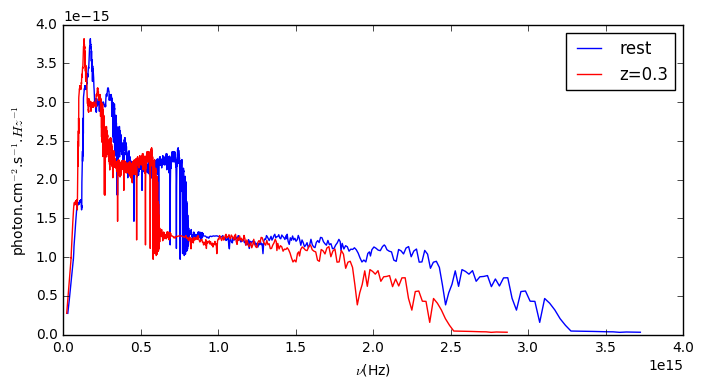

In [3]:
# flux density does not change, as expected.
plt.gcf().set_size_inches(8.,4.)
plt.plot(freq, flux, color='b', label='rest')
plt.plot(freq_r, flux_r, color='r', label='z='+str(z))
plt.xlabel(frequency_label)
plt.ylabel(photnu_label)
plt.legend()

### Now, pretend the original spectrum is expressed in $f_{\nu}$ as a function of $\nu$

In this case, flux density should drop by $(1+z)$ with redshift, and flux should drop with $(1+z)^{2}$ since the bandwidth $d_{\nu}$ drops with $(1+z)$ and photon energies also drop by $(1+z)$.

In [4]:
# pretend flux density is expressed in fnu for this test
flux_units = fnu

# again, build pretend frequency array based on the spectrum wavelengths
# and redshift it
freq = (wave * u.micron).to(u.Hz,  equivalencies=u.spectral())
freq_r = freq / (1.+z)

# convert from input units to photnu units, shift the spectral variable, and 
# convert back to photnu. This is the same python code as before.
a = (flux * flux_units).to(photnu, equivalencies=u.spectral_density(np.mean(freq))) 
flux_r = a.to(flux_units, equivalencies=u.spectral_density((np.mean(freq_r))))

# Compare total fluxes before and after the redshift.
delta = -(freq[1:] - freq[:-1])
sum_f = np.sum((flux[1:] * delta).value)
print("Total flux of input spectrum = %g" % sum_f)
delta = -(freq_r[1:] - freq_r[:-1])
sum_f = np.sum((flux_r[1:] * delta).value) * (1.+z)**2
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^2 = %g" % (z, sum_f))
# The total flux scales down by (1+z)**2 as expected.

Total flux of input spectrum = 4.15241
Total flux of redshifted spectrum at z=0.30, corrected by (1.+z)^2 = 4.15241


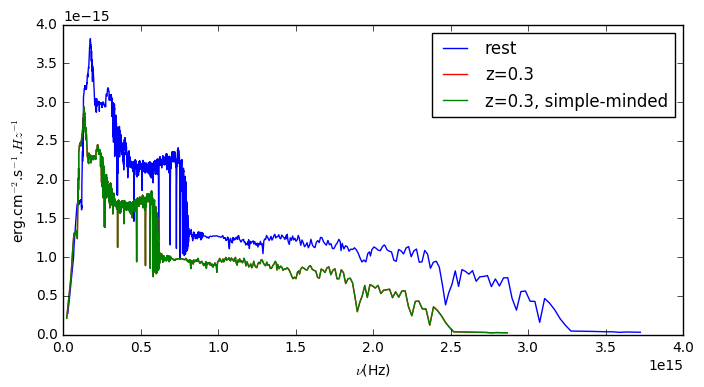

In [5]:
# flux density scales down by (1+z)
plt.gcf().set_size_inches(8.,4.)
plt.plot(freq, flux, color='b', label='rest')
plt.plot(freq_r, flux_r, color='r', label='z='+str(z))
plt.plot(freq_r, flux/(1.+z), color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(frequency_label)
plt.ylabel(fnu_label)
plt.legend()

### Encapsulate flux density correction in a function

Instead of repeating it over and over.

In [6]:
def redshift_correction(spectral_variable, redshifted_spectral_variable, flux_density):
    '''
    Parameters
    ----------
    spectral_variable: Quantity
        the independent spectral variable, with units, before 
        being redshifted
    redshifted_spectral_variable: Quantity
        the redshifted independent spectral variable, with units
    flux_density: Quantity
        the flux density, before being redshifted, with units

    Returns
    -------
    Quantity
        flux density values after being redshifted
    '''
    # convert from input units to photnu units, shift the spectral 
    # variable, then convert back from photnu to input units.
    midpoint = int(len(spectral_variable)/2)
    a = flux_density.to(u.photon/u.cm**2/u.s/u.Hz, equivalencies=u.spectral_density(spectral_variable[midpoint])) 
    return a.to(flux_density.unit, equivalencies=u.spectral_density(redshifted_spectral_variable[midpoint]))

### Apply to real data in this example: $f_{\lambda}$ as a function of $\lambda$

In [7]:
# use real data here. In the input spectrum, wavelenghts are 
# expressed in micron and flux densities in flam.
wave_r = wave * (1.+z)

# get corrected flux densities.
flux_r = redshift_correction(wave*u.micron, wave_r*u.micron, flux*flambda)

# Compare total fluxes before and after the redshift.
delta = wave[1:] - wave[:-1]
sum_f = np.sum((flux[1:] * delta))
print("Total flux of input spectrum = %g" % sum_f)
delta = wave_r[1:] - wave_r[:-1]
sum_f = np.sum((flux_r[1:] * delta).value) * (1.+z)**2
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^2 = %g" % (z, sum_f))
# The total flux scales down by (1+z)**2, since flux density drops with
# (1+z)**3 and the bandwidth scales up by (1+z). 

Total flux of input spectrum = 1.22286e-14
Total flux of redshifted spectrum at z=0.30, corrected by (1.+z)^2 = 1.22286e-14


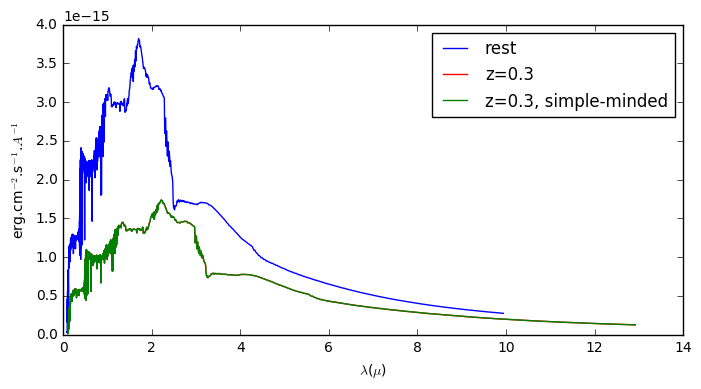

In [8]:
# flux density scales down by (1+z)**3
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux, color='b', label='rest')
plt.plot(wave_r, flux_r, color='r', label='z='+str(z))
plt.plot(wave_r, flux/(1.+z)**3, color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(micron_label)
plt.ylabel(flambda_label)
plt.legend()

### Pretend units: $f_{\nu}$ as a function of $\lambda$


This combination reproduces the behavior seen in ad-hoc examples as the one in Part 2 below: flux density drops with $(1+z)$, and flux remains constant.

In [9]:
wave_r = wave * (1.+z)
flux_r = redshift_correction(wave*u.micron, wave_r*u.micron, flux*fnu)

delta = wave[1:] - wave[:-1]
sum_f = np.sum((flux[1:] * delta))
print("Total flux of input spectrum = %g" % sum_f)
delta = wave_r[1:] - wave_r[:-1]
sum_f = np.sum((flux_r[1:] * delta).value)
print("Total flux of redshifted spectrum at z=%4.2f = %g" % (z, sum_f))

Total flux of input spectrum = 1.22286e-14
Total flux of redshifted spectrum at z=0.30 = 1.22286e-14


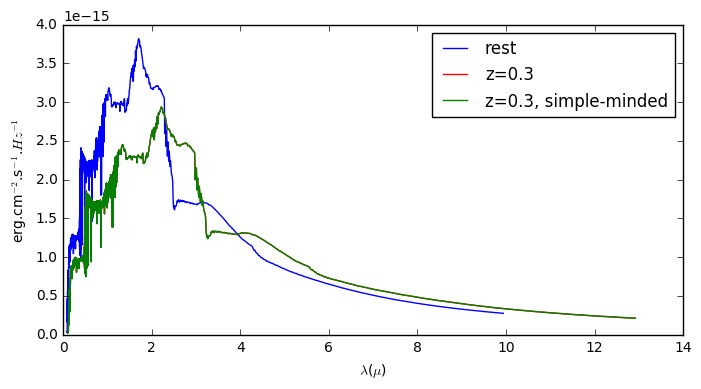

In [10]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux, color='b', label='rest')
plt.plot(wave_r, flux_r, color='r', label='z='+str(z))
plt.plot(wave_r, flux/(1.+z), color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(micron_label)
plt.ylabel(fnu_label)
plt.legend()

### Pretend units: $f_{\lambda}$ as a function of $\nu$

Flux density drops with $(1+z)^{3}$ and total flux drops with $(1+z)^{4}$

In [11]:
freq = (wave * u.micron).to(u.Hz,  equivalencies=u.spectral())
freq_r = freq / (1.+z)

flux_r = redshift_correction(freq, freq_r, flux*flambda)

delta = -(freq[1:] - freq[:-1])
sum_f = np.sum((flux[1:] * delta).value)
print("Total flux of input spectrum = %g" % sum_f)
delta = -(freq_r[1:] - freq_r[:-1])
sum_f = np.sum((flux_r[1:] * delta).value) * (1+z)**4
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^4 = %g" % (z, sum_f))

Total flux of input spectrum = 4.15241
Total flux of redshifted spectrum at z=0.30, corrected by (1.+z)^4 = 4.15241


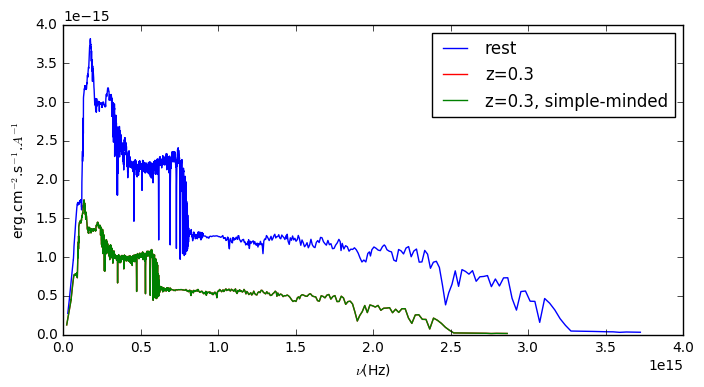

In [12]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(freq, flux, color='b', label='rest')
plt.plot(freq_r, flux_r, color='r', label='z='+str(z))
plt.plot(freq_r, flux/((1+z)**3), color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(frequency_label)
plt.ylabel(flambda_label)
plt.legend()

### Pretend units: $phot_{\nu}$ as a function of $\lambda$

In [13]:
wave_r = wave * (1.+z)
flux_r = redshift_correction(wave*u.micron, wave_r*u.micron, flux*photnu)

delta = wave[1:] - wave[:-1]
sum_f = np.sum((flux[1:] * delta))
print("Total flux of input spectrum = %g" % sum_f)
delta = wave_r[1:] - wave_r[:-1]
sum_f = np.sum((flux_r[1:] * delta).value) * (1+z)**(-1)
print("Total flux of redshifted spectrum at z=%4.2f = %g" % (z, sum_f))

Total flux of input spectrum = 1.22286e-14
Total flux of redshifted spectrum at z=0.30 = 1.22286e-14


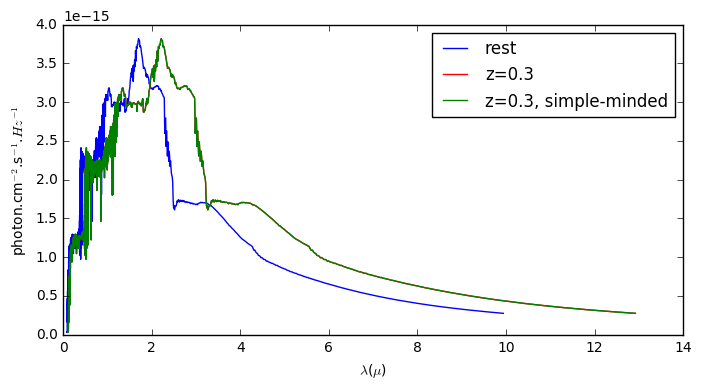

In [14]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux, color='b', label='rest')
plt.plot(wave_r, flux_r, color='r', label='z='+str(z))
plt.plot(wave_r, flux, color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(micron_label)
plt.ylabel(photnu_label)
plt.legend()

### Lets try with pretend energy units

In [15]:
energy = np.linspace(0.1,0.6,len(wave)) 
energy_r = energy / (1.+z)

flux_r = redshift_correction(energy*u.eV, energy_r*u.eV, flux*flambda)

delta = energy[1:] - energy[:-1]
sum_f = np.sum((flux[1:] * delta))
print("Total flux of input spectrum = %g" % sum_f)
delta = energy_r[1:] - energy_r[:-1]
sum_f = np.sum((flux_r[1:] * delta).value) * (1.+z)**4
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^4 = %g" % (z, sum_f))
# The total flux scales down by (1+z)**4. 

Total flux of input spectrum = 1.07854e-15
Total flux of redshifted spectrum at z=0.30, corrected by (1.+z)^4 = 1.07854e-15


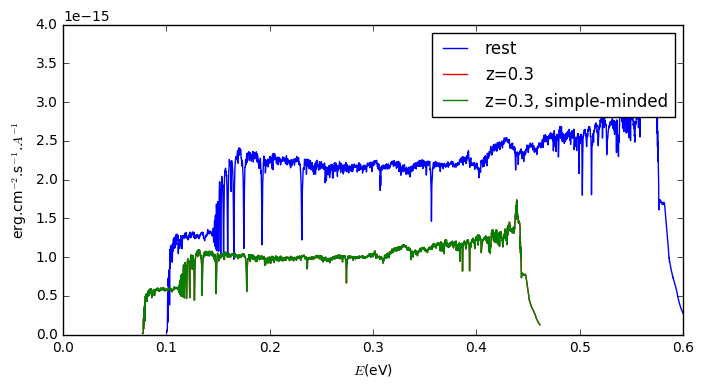

In [16]:
# flux density scales down by (1+z)**3
plt.gcf().set_size_inches(8.,4.)
plt.plot(energy, flux, color='b', label='rest')
plt.plot(energy_r, flux_r, color='r', label='z='+str(z))
plt.plot(energy_r, flux/(1.+z)**3, color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(energy_label)
plt.ylabel(flambda_label)
plt.legend()

### Use pysynphot to independently verify the above computations

#### THIS IS IN ERROR: I get different results from running the same script under different pysynphot installations.

Works with 0.9.7, gives wrong result with 0.9.8.6

Total flux of rest spectrum = 2.9997e-05
Total flux of redshifted spectrum at z=0.50, corrected by (1.+z)^2 = 6.74931e-05


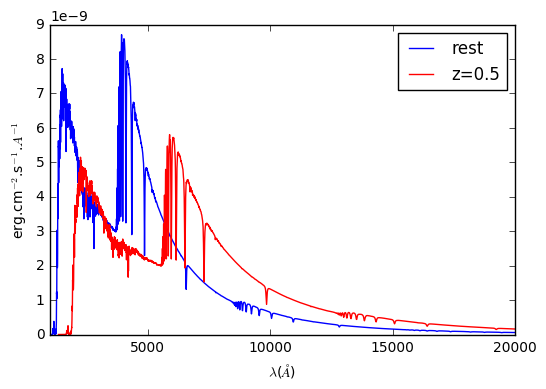

In [17]:
import pysynphot as S

vega = S.Vega
delta = vega.wave[1:] - vega.wave[:-1]
sum_f = np.sum(vega.flux[1:] * delta)
print("Total flux of rest spectrum = %g" % sum_f)
plt.plot(vega.wave, vega.flux, label='rest')

# Vega spectrum is expressed in flam units. We convert to 
# photnu units so flux density becomes invariant under 
# redshift transformations. Then we convert back to original
# flam units. 
z = 0.5
vega = S.Vega
vega.convert('photnu') 
vega = vega.redshift(z)
vega.convert('flam') 
delta = vega.wave[1:] - vega.wave[:-1]
sum_f = np.sum(vega.flux[1:] * delta) * (1.+z)**2
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^2 = %g" % (z, sum_f))
plt.plot(vega.wave, vega.flux, color='r', label='z='+str(z))
plt.xlabel(angstrom_label)
plt.ylabel(flambda_label)
plt.xlim(1000, 20000)
plt.legend()

## Summary

Flux density column: power to raise the $(1+z)$ factor to multiply the flux density to account for the effect of redshifting the spectrum.

Flux column: power to raise the $(1+z)$ factor to multiply the total flux to account for the effect of redshifting the spectrum.


|Flux density   | Spectral var.  |    Flux density      |     Flux            |
|---------------|----------------|----------------------|---------------------|
| $phot_{\nu}$  | ${\nu}$        |  0                   | -1                  |
| $phot_{\nu}$  | ${\lambda}$    |  0                   |  1                  |
| $f_{\nu}$     | ${\nu}$        | -1                   | -2                  |
| $f_{\nu}$     | $\lambda$      | -1                   |  0                  |
| $f_{\lambda}$ | $\nu$          | -3                   | -4                  |
| $f_{\lambda}$ | $\lambda$      | -3                   | -2                  |
| $f_{\lambda}$ | $E$            | -3                   | -4                  |





<h3>2 - Converting models to/from redshift z </h3>

Here we experiment with the model composition method to handle redshifts in the astropy context, including the issue of flux density corrections.

This example was directly taken from the astropy documentation, with just the addition of a total flux calculation.

Note that the normalization adopted here (scaling flux density down by $(1+z)$, and invariant total flux) is correct only when the data are expressed in $f_{\nu}$ as a function of $\lambda$

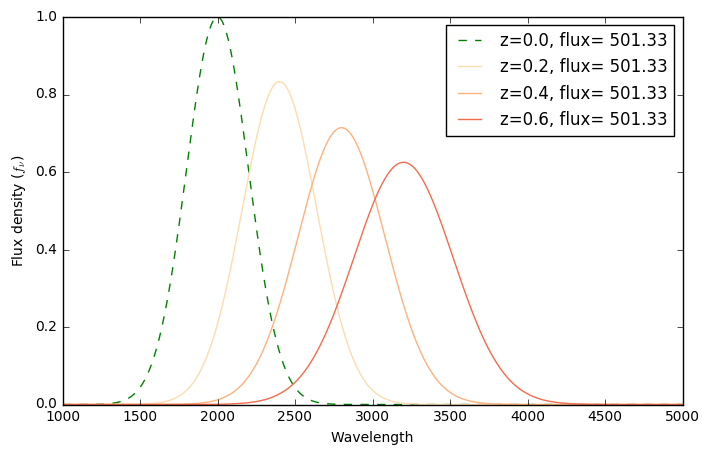

In [18]:
label_format = 'z={:.2}, flux={:7.2f}'
from astropy.modeling.models import RedshiftScaleFactor, Gaussian1D, Scale

x = np.linspace(1000, 5000, 1000)
dx = x[1:] - x[:-1]

g0 = Gaussian1D(1, 2000, 200) 
y = g0(x)
flux = np.sum(y[1:] * dx)
plt.figure(figsize=(8, 5))  
plt.plot(x, g0(x), 'g--', label=label_format.format(0., flux))

amplitude0 = g0.amplitude.value
for z in (0.2, 0.4, 0.6):
    rs = RedshiftScaleFactor(z).inverse
    sc = Scale(1. / (1 + z))
    y = (rs | g0 | sc)(x)
    flux = np.sum(y[1:] * dx)

    plt.plot(x, y, color=plt.cm.OrRd(z), label=label_format.format(z, flux))

plt.xlabel('Wavelength')
plt.ylabel(r'Flux density ($f_{\nu}$)')
plt.legend()

### 3 - Fitting for redshift

- generate fake spectrum with Gaussian at mean=6500, z=0.2
- generate Redshift-Gaussian composite model with mean=6500, z=0.1
- all 4 parameters are free
- fit - diverges into secondary minimum. The solution actually fits the data, but parameter values are meaningless.

INPUT MODEL:  Model: CompoundModel6
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <RedshiftScaleFactor(z=-0.09090909090909094)>

    [1]: <Gaussian1D(amplitude=100.0, mean=6500.0, stddev=200.0)>
Parameters:
          z_0        amplitude_1 mean_1 stddev_1
    ---------------- ----------- ------ --------
    -0.0909090909091       100.0 6500.0    200.0
FITTED MODEL:  Model: CompoundModel6
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <RedshiftScaleFactor(z=-0.09090909090909094)>

    [1]: <Gaussian1D(amplitude=100.0, mean=6500.0, stddev=200.0)>
Parameters:
         z_0       amplitude_1      mean_1       stddev_1   
    ------------- ------------- ------------- --------------
    33.1246850572 99.7037072824 266167.264374 -6782.37663307
FITTED z:  -0.970695700244


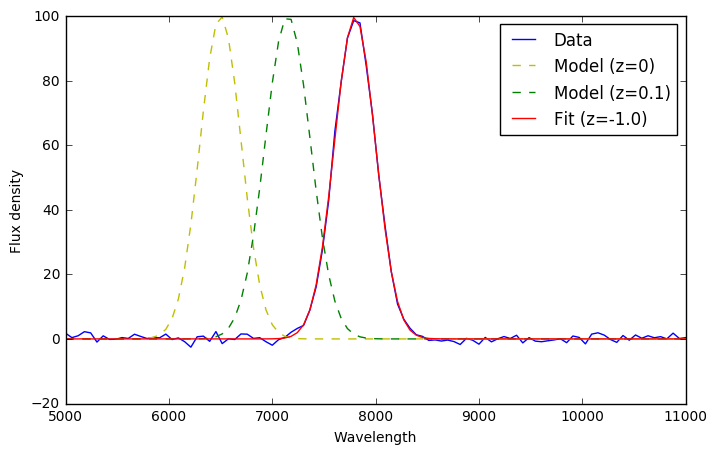

In [19]:
from astropy.modeling import models, fitting
plt.figure(figsize=(8, 5))  

# Generate fake data
np.random.seed(0)
x = np.linspace(5000, 11000, 100)
g0 = Gaussian1D(100, 6500 * 1.2, 200) 
y = g0(x)
y += np.random.normal(0., 1., x.shape)
plt.plot(x, y, 'blue', label='Data')

# redshifted Gaussian model
g1 = models.Gaussian1D(100, 6500, 200)
z = 0.1
rs = models.RedshiftScaleFactor(z).inverse
g_c = rs | g1

# fit
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_c, x, y, maxiter=2000)

# print parameters for model and solution
print("INPUT MODEL: ", g_c)
print("FITTED MODEL: ", g_fit)
fitted_z =  models.RedshiftScaleFactor(g_fit.parameters[0]).inverse.z.value
print("FITTED z: ", fitted_z)
plt.plot(x, g1(x), 'y--', label='Model (z=0)')
plt.plot(x, g_c(x), 'g--', label='Model (z=%3.1f)'%z)
plt.plot(x, g_fit(x), 'r', label='Fit (z=%3.1f)'%fitted_z)
plt.xlabel('Wavelength')
plt.ylabel('Flux density')
plt.legend()

- generate fake spectrum with Gaussian at mean=6500, z=0.2
- generate Redshift-Gaussian composite model with mean=6500, z=0.1
- fix Gaussian mean
- fit - diverges. No fit at all.
- fix Gaussian mean **and** stddev
- converges, but fit is not good
  - probably needs to iterate with the fix/fit switches until converging to better solution

{'mean_1': False, 'z_0': False, 'amplitude_1': False, 'stddev_1': False}
{'mean_1': True, 'z_0': False, 'amplitude_1': False, 'stddev_1': True}
INPUT MODEL:  Model: CompoundModel8
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <RedshiftScaleFactor(z=-0.09090909090909094)>

    [1]: <Gaussian1D(amplitude=100.0, mean=6500.0, stddev=200.0)>
Parameters:
          z_0        amplitude_1 mean_1 stddev_1
    ---------------- ----------- ------ --------
    -0.0909090909091       100.0 6500.0    200.0
FITTED MODEL:  Model: CompoundModel8
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <RedshiftScaleFactor(z=-0.09090909090909094)>

    [1]: <Gaussian1D(amplitude=100.0, mean=6500.0, stddev=200.0)>
Parameters:
          z_0        amplitude_1  mean_1 stddev_1
    --------------- ------------- ------ --------
    -0.166537778975 89.9424243517 6500.0    200.0
FITTED z:  0.199814430425


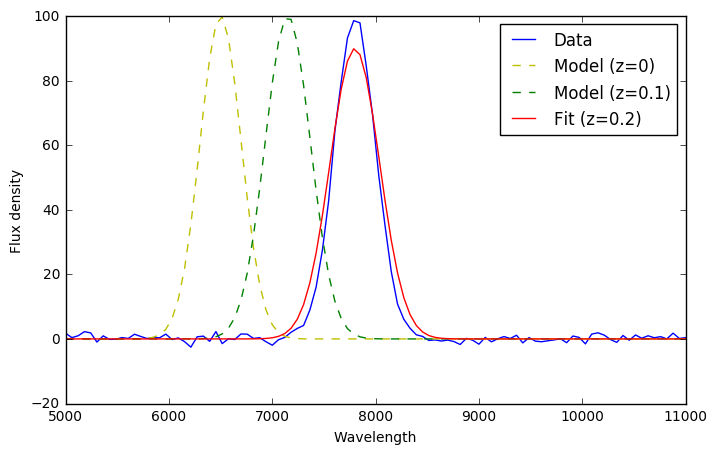

In [21]:
plt.figure(figsize=(8, 5))  

# Generate fake data
np.random.seed(0)
x = np.linspace(5000, 11000, 100)
g0 = Gaussian1D(100, 6500 * 1.2, 200) 
y = g0(x)
y += np.random.normal(0., 1., x.shape)
plt.plot(x, y, 'blue', label='Data')

# redshifted Gaussian model
g1 = models.Gaussian1D(100, 6500, 200)
z = 0.1
rs = models.RedshiftScaleFactor(z).inverse
g_c = rs | g1

# fix some parameters to force redshift to be fitted.
# Fixing just mean_1 still diverges (negative stddev).
print(g_c.fixed)
g_c.fixed['mean_1'] = True
g_c.fixed['stddev_1'] = True
print(g_c.fixed)

# fit
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_c, x, y, maxiter=2000)

# print parameters for model and solution
print("INPUT MODEL: ", g_c)
print("FITTED MODEL: ", g_fit)
fitted_z =  models.RedshiftScaleFactor(g_fit.parameters[0]).inverse.z.value
print("FITTED z: ", fitted_z)
plt.plot(x, g1(x), 'y--', label='Model (z=0)')
plt.plot(x, g_c(x), 'g--', label='Model (z=%3.1f)'%z)
plt.plot(x, g_fit(x), 'r', label='Fit (z=%3.1f)'%fitted_z)
plt.xlabel('Wavelength')
plt.ylabel('Flux density')
plt.legend()